In [370]:
import numpy as np
import theano
import theano.tensor as th
import matplotlib.pyplot as plt

from theano.tensor.nnet import conv2d
from theano.tensor.signal import pool

from scipy.io import loadmat
from sklearn.utils import shuffle

from datetime import datetime

In [371]:
df = pd.read_csv('./fer2013.csv')

In [372]:
df_training = df[df.Usage == 'Training']
df_public_testing = df[df.Usage == 'PublicTest']
df_private_testing = df[df.Usage == 'PrivateTest']

In [373]:
df.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [374]:
df_training.shape

(28709, 3)

In [375]:
df_public_testing.shape

(3589, 3)

In [376]:
df_private_testing.shape

(3589, 3)

In [377]:
X = []

for i in range(len(df)):
    l = df.pixels[i]
    ls = l.split()

    for i in range(len(ls)):
        ls[i] = float(ls[i])
    x = np.reshape(ls, (48, 48))
    X.append(x)

In [378]:
X = np.asarray(X)

In [379]:
X.shape

(35887, 48, 48)

In [380]:
Xtrain = X[ : df_training.shape[0]]
Xpublic_test = X[df_training.shape[0]:df_training.shape[0] + df_public_testing.shape[0]]
Xprivate_test = X[df_training.shape[0] + df_public_testing.shape[0]: ]

In [381]:
assert len(Xtrain) + len(Xpublic_test) + len(Xprivate_test) == len(X)

In [382]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [383]:
Y = df.emotion.as_matrix()

C:\Users\hongj\Anaconda2\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [384]:
Ytrain = Y[ : df_training.shape[0]] 
Ypublic_test = Y[df_training.shape[0]:df_training.shape[0] + df_public_testing.shape[0]] 
Yprivate_test = Y[df_training.shape[0] + df_public_testing.shape[0]: ] 

In [385]:
Ytrain

array([0, 0, 2, ..., 4, 0, 4], dtype=int64)

In [386]:
Ytrain = Ytrain.astype(int)
Ypublic_test = Ypublic_test.astype(int)
Yprivate_test = Yprivate_test.astype(int)

In [387]:
type(Ytrain[0])

numpy.int32

In [388]:
assert len(Ytrain) + len(Ypublic_test) + len(Yprivate_test) == len(Y)

In [389]:
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [390]:
def emotion_indicator(number):
    return label_map[number]

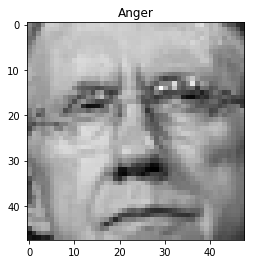

In [391]:
k = 123

plt.imshow(Xtrain[k], cmap = 'gray')
plt.title(emotion_indicator(Ytrain[k]))
plt.show()

In [392]:
def reshape(data):
    l = []

    for i in range(len(data)):
        l.append([data[i]])

    data = np.asarray(l)
    return (data/255.0).astype(np.float32)

In [393]:
Xtrain = reshape(Xtrain)
Xpublic_test = reshape(Xpublic_test)
Xprivate_test = reshape(Xprivate_test)

In [394]:
Xtrain.shape[1]

1

In [414]:
max_iter = 12
print_period = 30

lr = np.float32(1e-2)
mu = np.float32(0.99)

N = Xtrain.shape[0]
batch_sz = 500
n_batches = N // batch_sz

M = 500
K = 7
poolsz = (2, 2)

In [415]:
def init_filter(shape, poolsz):
    # w = np.random.randn(*shape) / np.sqrt(np.prod(shape[1:]) + shape[0]*np.prod(shape[2:]) / np.prod(poolsz))
    w = np.random.randn(*shape) * np.sqrt(2.0 / np.prod(shape[1:]))
    return w.astype(np.float32)

In [416]:
W1_shape = (20, Xtrain.shape[1], 5, 5) # (num_feature_maps, num_color_channels, filter_width, filter_height)
W1_init = init_filter(W1_shape, poolsz)
b1_init = np.zeros(W1_shape[0], dtype=np.float32) # one bias per output feature map

In [417]:
# after conv will be of dimension 
# after downsample 10 / 2 = 5
W2_shape = (50, W1_shape[0], 5, 5) # (num_feature_maps, old_num_feature_maps, filter_width, filter_height)
W2_init = init_filter(W2_shape, poolsz)
b2_init = np.zeros(W2_shape[0], dtype=np.float32)

In [418]:
#valid mode

ac1 = (Xtrain.shape[2] - W1_shape[2] + 1) 
ap1 = ac1 / poolsz[0]
ac2 = ( ap1 - W2_shape[2] + 1 )
ap2 = ac2 / poolsz[0]
ap2 = int(ap2)
print(ap2)

9


In [419]:
type(ap2)

int

In [420]:
# vanilla ANN weights
W3_init = np.random.randn(W2_shape[0]*ap2*ap2, M) / np.sqrt(W2_shape[0]*ap2*ap2 + M)
b3_init = np.zeros(M, dtype=np.float32)
W4_init = np.random.randn(M, K) / np.sqrt(M + K)
b4_init = np.zeros(K, dtype=np.float32)

In [421]:
# step 2: define theano variables and expressions
X = th.tensor4('X', dtype='float32') #Return a Variable for a 4-dimensional ndarray 
Y = th.ivector('T')
W1 = theano.shared(W1_init, 'W1')
b1 = theano.shared(b1_init, 'b1')
W2 = theano.shared(W2_init, 'W2')
b2 = theano.shared(b2_init, 'b2')
W3 = theano.shared(W3_init.astype(np.float32), 'W3')
b3 = theano.shared(b3_init, 'b3')
W4 = theano.shared(W4_init.astype(np.float32), 'W4')
b4 = theano.shared(b4_init, 'b4')

In [422]:
def relu(a):
    return a * (a > 0)

In [423]:
def convpool(X, W, b, poolsize=(2, 2)):
    conv_out = conv2d(input=X, filters=W)

    # downsample each feature map individually, using maxpooling
    pooled_out = pool.pool_2d(
        input=conv_out,
        ws=poolsize,
        ignore_border=True
    )

    # add the bias term. Since the bias is a vector (1D array), we first
    # reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
    # thus be broadcasted across mini-batches and feature map
    # width & height
    # return T.tanh(pooled_out + b.dimshuffle('x', 0, 'x', 'x'))
    return relu(pooled_out + b.dimshuffle('x', 0, 'x', 'x'))


In [424]:
# forward pass
Z1 = convpool(X, W1, b1)
Z2 = convpool(Z1, W2, b2)
Z3 = relu(Z2.flatten(ndim=2).dot(W3) + b3)
pY = th.nnet.softmax( Z3.dot(W4) + b4)

In [425]:
# define the cost function and prediction
cost = -(th.log(pY[th.arange(Y.shape[0]), Y])).mean()
prediction = th.argmax(pY, axis=1)

In [426]:
# step 3: training expressions and functions
params = [W1, b1, W2, b2, W3, b3, W4, b4]

In [427]:
# momentum changes
dparams = [
    theano.shared(
        np.zeros_like(
            p.get_value(),
            dtype=np.float32
        )
    ) for p in params
]

In [428]:
updates = []
grads = th.grad(cost, params)
for p, dp, g in zip(params, dparams, grads):
    dp_update = mu*dp - lr*g
    p_update = p + dp_update

    updates.append((dp, dp_update))
    updates.append((p, p_update))

In [429]:
train = theano.function(
        inputs=[X, Y],
        updates=updates,
    )

In [430]:
# create another function for this because we want it over the whole dataset
get_prediction = theano.function(
    inputs=[X, Y],
    outputs=[cost, prediction],
)

In [431]:
def error_rate(p, t):
    return np.mean(p != t)

Cost / err at iteration i=0, j=0: 1.903 / 0.751
Cost / err at iteration i=0, j=30: 1.815 / 0.750
Cost / err at iteration i=1, j=0: 1.758 / 0.711
Cost / err at iteration i=1, j=30: 1.664 / 0.643
Cost / err at iteration i=2, j=0: 1.642 / 0.629
Cost / err at iteration i=2, j=30: 1.570 / 0.597
Cost / err at iteration i=3, j=0: 1.523 / 0.581
Cost / err at iteration i=3, j=30: 1.502 / 0.572
Cost / err at iteration i=4, j=0: 1.484 / 0.571
Cost / err at iteration i=4, j=30: 1.438 / 0.549
Cost / err at iteration i=5, j=0: 1.425 / 0.547
Cost / err at iteration i=5, j=30: 1.398 / 0.534
Cost / err at iteration i=6, j=0: 1.356 / 0.514
Cost / err at iteration i=6, j=30: 1.335 / 0.507
Cost / err at iteration i=7, j=0: 1.359 / 0.510
Cost / err at iteration i=7, j=30: 1.338 / 0.512
Cost / err at iteration i=8, j=0: 1.301 / 0.488
Cost / err at iteration i=8, j=30: 1.329 / 0.496
Cost / err at iteration i=9, j=0: 1.328 / 0.487
Cost / err at iteration i=9, j=30: 1.308 / 0.483
Cost / err at iteration i=10, 

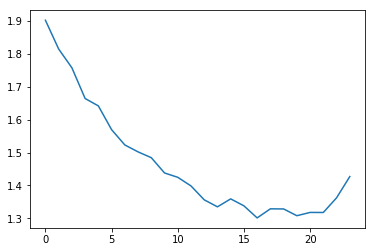

In [432]:
t0 = datetime.now()
costs = []
for i in range(max_iter):
    Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
    for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain[j*batch_sz:(j*batch_sz + batch_sz),]

        train(Xbatch, Ybatch)
        if j % print_period == 0:
            cost_val, prediction_val = get_prediction(Xpublic_test, Ypublic_test)
            err = error_rate(prediction_val, Ypublic_test)
            print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, cost_val, err))
            costs.append(cost_val)
print("Elapsed time:", (datetime.now() - t0))
plt.plot(costs)
plt.show()